Описание метрик и обоснование выбора ниже по коду

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchmetrics import R2Score
from sklearn.model_selection import KFold
from torchmetrics.classification import BinaryAUROC

In [3]:
root_path = ""

In [4]:
person = pd.read_csv(root_path + "person.csv")
person.shape

(189118, 42)

In [5]:
all_action_train = pd.read_csv(root_path + "action_train.csv")
all_action_train = all_action_train.sample(300000)

msk = np.random.rand(len(all_action_train)) < 0.7

action_train = all_action_train[msk]
action_val = all_action_train[~msk]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


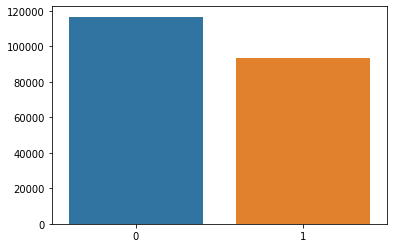

In [6]:
# Проверка сбалансированности данных.
dd = pd.Series(action_train.result).value_counts()
sns.barplot(x=np.array(['0','1']),y=dd.values)
plt.show()

In [7]:
pd.set_option('max_columns', None)
person.loc[person.person_id == "ppl_100"]

,Unnamed: 0,person_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36


In [11]:
action_train.head()

,Unnamed: 0,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,result
1719607,1719607,ppl_377724,act2_2383305,2023-02-11,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,1
1507839,1507839,ppl_351461,act2_405403,2022-10-12,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
1346707,1346707,ppl_321647,act2_4127913,2022-10-14,type 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3,0
1985396,1985396,ppl_63533,act2_339051,2022-09-16,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 208,1
1596541,1596541,ppl_366539,act2_2663423,2023-03-01,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [12]:
action_train = action_train.drop(["date", 'Unnamed: 0', 'action_id'], axis=1)
action_val = action_val.drop(["date", 'Unnamed: 0', 'action_id'], axis=1)

In [13]:
# Выбираю столбцы с кат. признаками для кодирования
action_encode_columns = action_train.columns[1:12]
action_encode_columns

Index(['action_type', 'char_1', 'char_2', 'char_3', 'char_4', 'char_5',
       'char_6', 'char_7', 'char_8', 'char_9', 'char_10'],
      dtype='object')

In [14]:
# Для кодирования был выбран BinaryEncoder в силу огромного множества признаков
encoder = ce.BinaryEncoder(cols=action_encode_columns, return_df=True)
encoder.fit(action_train)
x_action_train = encoder.transform(action_train)
x_action_val = encoder.transform(action_val)

In [15]:
person = person.drop(["group_1", "date", 'Unnamed: 0'], axis=1)

In [16]:
person_categorical_columns = person.columns[1:10]
person_boolean_columns = person.columns[10:38]
person_categorical_columns

Index(['char_1', 'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7',
       'char_8', 'char_9'],
      dtype='object')

In [17]:
encoder = ce.BinaryEncoder(cols=person_categorical_columns, return_df=True)
x_person_data = encoder.fit_transform(person)

In [18]:
# Перевожу bool значения в 0/1
x_person_data[person_boolean_columns] = x_person_data[person_boolean_columns].astype(int)

In [19]:
x_person_data

,person_id,char_1_0,char_1_1,char_2_0,char_2_1,char_3_0,char_3_1,char_3_2,char_3_3,char_3_4,char_3_5,char_4_0,char_4_1,char_4_2,char_4_3,char_4_4,char_5_0,char_5_1,char_5_2,char_5_3,char_6_0,char_6_1,char_6_2,char_7_0,char_7_1,char_7_2,char_7_3,char_7_4,char_8_0,char_8_1,char_8_2,char_8_3,char_9_0,char_9_1,char_9_2,char_9_3,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36
1,ppl_100002,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76
2,ppl_100003,0,1,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,99
3,ppl_100004,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76
4,ppl_100006,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189113,ppl_99987,1,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,1,1,0,0,1,0,0,0,1,0,1,0,1,1,89
189114,ppl_9999,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
189115,ppl_99992,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
189116,ppl_99994,0,1,1,0,0,0,1,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,95


In [20]:
scaler = StandardScaler()
char38_array = np.asarray(x_person_data.char_38).reshape(-1, 1)
scaler.fit(char38_array)
char38_array = scaler.transform(char38_array)

In [21]:
x_person_data.char_38 = char38_array

In [22]:
# Сопоставляю данные о человеке и действии
left = x_action_train
right = x_person_data

train_merged_df = pd.merge(left, right, on="person_id", how="left")

left = x_action_val
val_merged_df = pd.merge(left, right, on="person_id", how="left")

In [23]:
train_merged_df = train_merged_df.drop("person_id", axis=1)
val_merged_df = val_merged_df.drop("person_id", axis=1)

In [24]:
x_train_df = train_merged_df.drop("result", axis=1)
y_train_df = train_merged_df["result"]

x_val_df = val_merged_df.drop("result", axis=1)
y_val_df = val_merged_df["result"]

In [25]:
class ActionDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.to_numpy(), dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        self.length = self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.length

In [26]:
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_shape, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.sig(out)
        
        return out


In [27]:
def validate_data(model, x_data, y_data):
    model.eval()
    predicted = model(x_data)
    r2score = R2Score()
    return r2score(predicted, y_data.reshape(-1, 1))


In [29]:
x_val = torch.tensor(x_val_df.to_numpy()).float()
y_val = torch.tensor(y_val_df.to_numpy()).float()

# Метрики

Были выбраны следующие метрики:

1. BCELoss
Binary Cross Entropy Loss был выбран, поскольку задача похожа на бинарную классификацию, а BCELoss является одним из лучших выборов для подобных задач. Также из-за понятной интерпретируемости функции потерь - вероятность от 0 до 1. 

2. R2 Score
R2 Score был выбран, поскольку является одной из самых распространенных метрик для задач регрессии, а также из-за понятной интерпретации: если близка к 1, то модель хорошо объясняет данные, если же близка к нулю, то прогнозы сопоставимы по качеству с константным предсказанием. Также преимуществом является, что, фактически, коэффициент детерминации является нормированной среднеквадратичной ошибкой, поэтому не зависит от масштабов данных (в отличие от MSE).
R2 Score для ансамбля обученных моделей 0.7526. Стоит учитывать, что для обучения моделей использовалась не вся выборка (300к) из-за ограничений в вычислительных мощностях, поэтому метрика немного занижена.

3. Accuracy
Был выбран accuracy, так как является интуитивно понятным. Также задача очень похожа на бинарную классификацию, поэтому с округлением результатов можно оценить качество модели на предсказание классов. Accuracy является около-бесполезной в задачах с неравными классами, однако в этой задаче датасет сбалансирован, поэтому можно опираться на этот показатель.
На валидационной выборке accuracy ~0.97.

4. AUC-ROC
Задача похожа на бинарную классификацию, поэтому для оценки качества модели можно использовать площадь под ROC кривой. По сути, алгоритм подбирает порог t для предсказаний: если порог можно подобрать так, что модель не будет допускать ошибок, то AUC-ROC будет равен единице, если же модель выдает случайные результаты, то AUC-ROC будет близок 0.5. 
Для обученной модели AUC-ROC равен 0.9719.

Все вычисления метрик представлены ниже.

In [31]:
torch.manual_seed(42)

device = torch.device("cpu")

losses = []
accur = []

epochs = 30

r2score = R2Score().to(device)

# Деление датасета для кросс-валидации
k_folds_num = 5
k_fold = KFold(n_splits=k_folds_num, shuffle=True)

models = []

for fold, (train_ids, val_ids) in enumerate(k_fold.split(x_train_df)):
    print(f'FOLD {fold}')
    print('-' * 10)
    
    x_train_fold = x_train_df.iloc[train_ids]
    y_train_fold = y_train_df.iloc[train_ids]
    
    x_val_fold = x_train_df.iloc[val_ids]
    x_val_fold = torch.tensor(x_val_fold.to_numpy()).float()
    y_val_fold = y_train_df.iloc[val_ids]
    y_val_fold = torch.tensor(y_val_fold.to_numpy()).float()
    
    trainset = ActionDataset(x_train_fold, y_train_fold)
    train_loader = DataLoader(trainset, batch_size=64, shuffle=False)
    
    model = Net(input_shape=x_train_fold.shape[1])
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_fn = nn.BCELoss()

    model.to(device)
    
    for epoch in range(epochs):
        for j, (x_train, y_train) in enumerate(train_loader):
            model.train()
            
            output = model(x_train.to(device))
    
            loss = loss_fn(output, y_train.reshape(-1, 1).to(device))
            
            acc = r2score(output, y_train.reshape(-1, 1).to(device)).to(device)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            losses.append(loss)
            accur.append(acc)
    
        val_accur = validate_data(model, x_val_fold, y_val_fold)
        predicted = model(torch.tensor(x_train_fold.to_numpy()).float().to(device))
        predicted_val = model(x_val_fold.to(device))
                
        round_accur = 1 - (((predicted.detach().flatten().round() - y_train_fold).sum()) / predicted.shape[0])
        round_accur_val = 1 - (((predicted_val.round() - y_val_fold.reshape(-1, 1)).sum()) / predicted_val.shape[0])
    
        print(f"epoch {epoch}\tloss : {loss}\t r2_score : {accur[-1]}\t val_r2_score: {val_accur}"
              f"  round_accur: {round_accur} round_accur_val: {round_accur_val}")
    
    models.append(model)
    

FOLD 0
----------
epoch 0	loss : 0.339267760515213	 r2_score : 0.5358405709266663	 val_r2_score: 0.5992208123207092  round_accur: 0.899912621186093 round_accur_val: 0.900116503238678
epoch 1	loss : 0.2843616008758545	 r2_score : 0.5959173440933228	 val_r2_score: 0.618911623954773  round_accur: 0.9095361789898534 round_accur_val: 0.9086996912956238
epoch 2	loss : 0.2576106786727905	 r2_score : 0.6435414552688599	 val_r2_score: 0.6333924531936646  round_accur: 0.9173467750084704 round_accur_val: 0.916474461555481
epoch 3	loss : 0.25421011447906494	 r2_score : 0.6413142681121826	 val_r2_score: 0.6357088685035706  round_accur: 0.9130075549981276 round_accur_val: 0.911885678768158
epoch 4	loss : 0.22020123898983002	 r2_score : 0.6927936673164368	 val_r2_score: 0.6471047401428223  round_accur: 0.9241349794630067 round_accur_val: 0.9218240976333618
epoch 5	loss : 0.21691106259822845	 r2_score : 0.6994869709014893	 val_r2_score: 0.6466977000236511  round_accur: 0.936290739628967 round_accur_va

epoch 19	loss : 0.22423703968524933	 r2_score : 0.6557655334472656	 val_r2_score: 0.6907854080200195  round_accur: 0.9672240285794107 round_accur_val: 0.9628617167472839
epoch 20	loss : 0.23434393107891083	 r2_score : 0.6679273843765259	 val_r2_score: 0.6871241927146912  round_accur: 0.9766098209031522 round_accur_val: 0.9727287888526917
epoch 21	loss : 0.21201957762241364	 r2_score : 0.6818539500236511	 val_r2_score: 0.6943891644477844  round_accur: 0.9736555848139188 round_accur_val: 0.9685441851615906
epoch 22	loss : 0.2929973006248474	 r2_score : 0.638988733291626	 val_r2_score: 0.6821499466896057  round_accur: 0.981430516010533 round_accur_val: 0.977103590965271
epoch 23	loss : 0.3638501763343811	 r2_score : 0.5126746296882629	 val_r2_score: 0.6818581223487854  round_accur: 0.9774598324942193 round_accur_val: 0.9713259935379028
epoch 24	loss : 0.2924458980560303	 r2_score : 0.5801754593849182	 val_r2_score: 0.6882036924362183  round_accur: 0.9828868295756481 round_accur_val: 0.978

epoch 8	loss : 0.20675618946552277	 r2_score : 0.7165287733078003	 val_r2_score: 0.676211953163147  round_accur: 0.9440481709999168 round_accur_val: 0.9407960176467896
epoch 9	loss : 0.2115604132413864	 r2_score : 0.7166322469711304	 val_r2_score: 0.6797912120819092  round_accur: 0.9476027437973299 round_accur_val: 0.9450045228004456
epoch 10	loss : 0.18306267261505127	 r2_score : 0.7559353113174438	 val_r2_score: 0.6781104207038879  round_accur: 0.9583140150029126 round_accur_val: 0.9563459753990173
epoch 11	loss : 0.19717559218406677	 r2_score : 0.7203693389892578	 val_r2_score: 0.6804323196411133  round_accur: 0.9605608854333845 round_accur_val: 0.9585334658622742
epoch 12	loss : 0.1648828685283661	 r2_score : 0.772471010684967	 val_r2_score: 0.6842575073242188  round_accur: 0.9553716846772947 round_accur_val: 0.9523990750312805
epoch 13	loss : 0.17503555119037628	 r2_score : 0.7536137104034424	 val_r2_score: 0.6852781772613525  round_accur: 0.964299725382503 round_accur_val: 0.9617

epoch 27	loss : 0.23612971603870392	 r2_score : 0.6658841371536255	 val_r2_score: 0.704796314239502  round_accur: 0.9798851599557759 round_accur_val: 0.9752960205078125
epoch 28	loss : 0.2383904755115509	 r2_score : 0.6550683379173279	 val_r2_score: 0.7055268287658691  round_accur: 0.9774718546786024 round_accur_val: 0.9730134606361389
epoch 29	loss : 0.24205616116523743	 r2_score : 0.6582434177398682	 val_r2_score: 0.7077338695526123  round_accur: 0.9796295635840555 round_accur_val: 0.9757239818572998


In [63]:
def get_ensemble_score(models, data):
    final_score = 0

    for model in models:
        final_score += (1 / k_folds_num) * model(data)
    
    return final_score

In [65]:
final_score = get_ensemble_score(models, x_val)

In [66]:
# R2 score ансамбля моделей на вал. выборке.
r2score = R2Score()
print(r2score(final_score, y_val.reshape(-1, 1)))

tensor(0.7526, grad_fn=<SqueezeBackward0>)


In [83]:
# AUC-ROC
binary_aucroc = BinaryAUROC(thresholds=None)
binary_aucroc(final_score, y_val.reshape(-1, 1))

tensor(0.9719)

In [36]:
raw_action_test = pd.read_csv(root_path + "action_test.csv")


,Unnamed: 0,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN
3,3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,type 1,type 5,type 5,NaN
4,4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498682,498682,ppl_99997,act2_4367092,2023-04-22,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1
498683,498683,ppl_99997,act2_4404220,2022-11-12,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1
498684,498684,ppl_99997,act2_448830,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1
498685,498685,ppl_99997,act2_450133,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1


In [70]:
action_test = raw_action_test.drop(["date", 'Unnamed: 0', 'action_id'], axis=1)

encoder = ce.BinaryEncoder(cols=action_encode_columns, return_df=True)
encoder.fit(action_train)

action_test["result"] = 0

action_test = encoder.transform(action_test)

action_test = action_test.drop("result", axis=1)

left = action_test
right = x_person_data

test_merged_df = pd.merge(left, right, on="person_id", how="left")

test_merged_df = test_merged_df.drop("person_id", axis=1)
test_merged_df

,action_type_0,action_type_1,action_type_2,char_1_0_x,char_1_1_x,char_1_2,char_1_3,char_1_4,char_1_5,char_2_0_x,char_2_1_x,char_2_2,char_2_3,char_2_4,char_2_5,char_3_0_x,char_3_1_x,char_3_2_x,char_3_3_x,char_4_0_x,char_4_1_x,char_4_2_x,char_4_3_x,char_5_0_x,char_5_1_x,char_5_2_x,char_6_0_x,char_6_1_x,char_6_2_x,char_7_0_x,char_7_1_x,char_7_2_x,char_7_3_x,char_8_0_x,char_8_1_x,char_8_2_x,char_8_3_x,char_8_4,char_9_0_x,char_9_1_x,char_9_2_x,char_9_3_x,char_9_4,char_10_0,char_10_1,char_10_2,char_10_3,char_10_4,char_10_5,char_10_6,char_10_7,char_10_8,char_10_9,char_10_10,char_10_11,char_10_12,char_1_0_y,char_1_1_y,char_2_0_y,char_2_1_y,char_3_0_y,char_3_1_y,char_3_2_y,char_3_3_y,char_3_4,char_3_5,char_4_0_y,char_4_1_y,char_4_2_y,char_4_3_y,char_4_4,char_5_0_y,char_5_1_y,char_5_2_y,char_5_3,char_6_0_y,char_6_1_y,char_6_2_y,char_7_0_y,char_7_1_y,char_7_2_y,char_7_3_y,char_7_4,char_8_0_y,char_8_1_y,char_8_2_y,char_8_3_y,char_9_0_y,char_9_1_y,char_9_2_y,char_9_3_y,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,1,0,1,1,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0.718074
1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0.718074
2,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0,1,1,0,1,1,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1.109660
3,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,1,1,0,1,1,0,1,1,0,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1.109660
4,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1.109660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498682,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.400744
498683,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.400744
498684,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.400744
498685,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.400744


In [71]:
x_test = torch.tensor(test_merged_df.to_numpy()).float()

result = get_ensemble_score(models, x_test)

In [74]:
test_output = pd.DataFrame()
test_output["action_id"]  = raw_action_test["action_id"]
test_output["result"] = result.detach().numpy()
test_output

,action_id,result
0,act1_249281,6.861875e-01
1,act2_230855,6.093983e-01
2,act1_240724,7.026474e-01
3,act1_83552,6.631950e-01
4,act2_1043301,7.642440e-01
...,...,...
498682,act2_4367092,1.076240e-11
498683,act2_4404220,1.076240e-11
498684,act2_448830,1.076238e-11
498685,act2_450133,1.076238e-11


In [79]:
test_output.to_csv("test_output.csv", index=False)